# Прогнозирование температуры звезды

Вам пришла задача от обсерватории «Небо на ладони»: придумать, как с помощью нейросети определять температуру на поверхности обнаруженных звёзд. Обычно для расчёта температуры учёные пользуются следующими методами:  
* Закон смещения Вина.
* Закон Стефана-Больцмана.
* Спектральный анализ.  
Каждый из них имеет плюсы и минусы. Обсерватория хочет внедрить технологии машинного обучения для предсказания температуры звёзд, надеясь, что этот метод будет наиболее точным и удобным.  
В базе обсерватории есть характеристики уже изученных 240 звёзд.

## Характеристики

Относительная светимость $L$/$L_o$ — светимость звезды относительно Солнца.  
Относительный радиус $R$/$R_o$ — радиус звезды относительно радиуса Солнца.  
Абсолютная звёздная величина $Mv$ — физическая величина, характеризующая блеск звезды.  
Звёздный цвет (white, red, blue, yellow, yellow-orange и др.) — цвет звезды, который определяют на основе спектрального анализа.  

Тип звезды:  	
* Коричневый карлик — 0  
* Красный карлик — 1  
* Белый карлик — 2  
* Звёзды главной последовательности — 3  
* Сверхгигант — 4  
* Гипергигант — 5  


Абсолютная температура T(K) — температура на поверхности звезды в Кельвинах.

Необходимо разработать нейронную сеть, которая поможет предсказывать абсолютную температуру на поверхности звезды.  


💡 Справочная информация:  
Светимость Солнца (англ. _Average Luminosity of Sun_)  
 
$$L_0 = 3.828 ⋅ 10^{26} Вт$$


Радиус Солнца (англ. _Average Radius of Sun_) 
 
$$R_0 = 6.9551 ⋅ 10^8 м$$

# Загрузка данных

In [2]:
import matplotlib.pyplot as plt
from math import ceil
import numpy as np 
import os
import pandas as pd
import phik
from phik.report import plot_correlation_matrix
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import make_column_transformer, make_column_selector
import torch
import torch.nn as nn
from tqdm import tqdm


# RandomState
RS = 4624365
np.random.seed(RS)
torch.manual_seed(RS)
torch.cuda.manual_seed(RS)
torch.backends.cudnn.deterministic = True	
torch.use_deterministic_algorithms(True)


In [3]:
pth1 = 's31.csv'

if os.path.exists(pth1):
    data = pd.read_csv(pth1)
elif not os.path.exists(pth1):
    data = pd.read_csv('/datasets/6_class.csv')
else:
    print('Something is wrong')

data.head()

,Unnamed: 0,Unnamed: 0.1,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color
0,0,0,3068,0.002400,0.1700,16.12,0,Red
1,1,1,3042,0.000500,0.1542,16.60,0,Red
2,2,2,2600,0.000300,0.1020,18.70,0,Red
3,3,3,2800,0.000200,0.1600,16.65,0,Red
4,4,4,1939,0.000138,0.1030,20.06,0,Red


In [4]:
data = data.drop(['Unnamed: 0'], axis=1)

In [5]:
# функция для ознакомления с данными

def first_look(data):
    display(data.info())
    print()
    display(data.describe())
    print()
    print('Дубликатов обнаружено: ', data.duplicated().sum())
    print()
    data.hist(figsize=(25, 15))
    plt.show()
    print()
    print('Размер датасета:', data.shape)
    print()
    print('Пропуски')
    print(data.isna().sum())
    display(data.sample(40))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Unnamed: 0.1            240 non-null    int64  
 1   Temperature (K)         240 non-null    int64  
 2   Luminosity(L/Lo)        240 non-null    float64
 3   Radius(R/Ro)            240 non-null    float64
 4   Absolute magnitude(Mv)  240 non-null    float64
 5   Star type               240 non-null    int64  
 6   Star color              240 non-null    object 
dtypes: float64(3), int64(3), object(1)
memory usage: 13.2+ KB


None

,Unnamed: 0.1,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type
count,240.00000,240.000000,240.000000,240.000000,240.000000,240.000000
mean,119.50000,10497.462500,107188.361635,237.157781,4.382396,2.500000
std,69.42622,9552.425037,179432.244940,517.155763,10.532512,1.711394
min,0.00000,1939.000000,0.000080,0.008400,-11.920000,0.000000
25%,59.75000,3344.250000,0.000865,0.102750,-6.232500,1.000000
50%,119.50000,5776.000000,0.070500,0.762500,8.313000,2.500000
75%,179.25000,15055.500000,198050.000000,42.750000,13.697500,4.000000
max,239.00000,40000.000000,849420.000000,1948.500000,20.060000,5.000000



Дубликатов обнаружено:  0



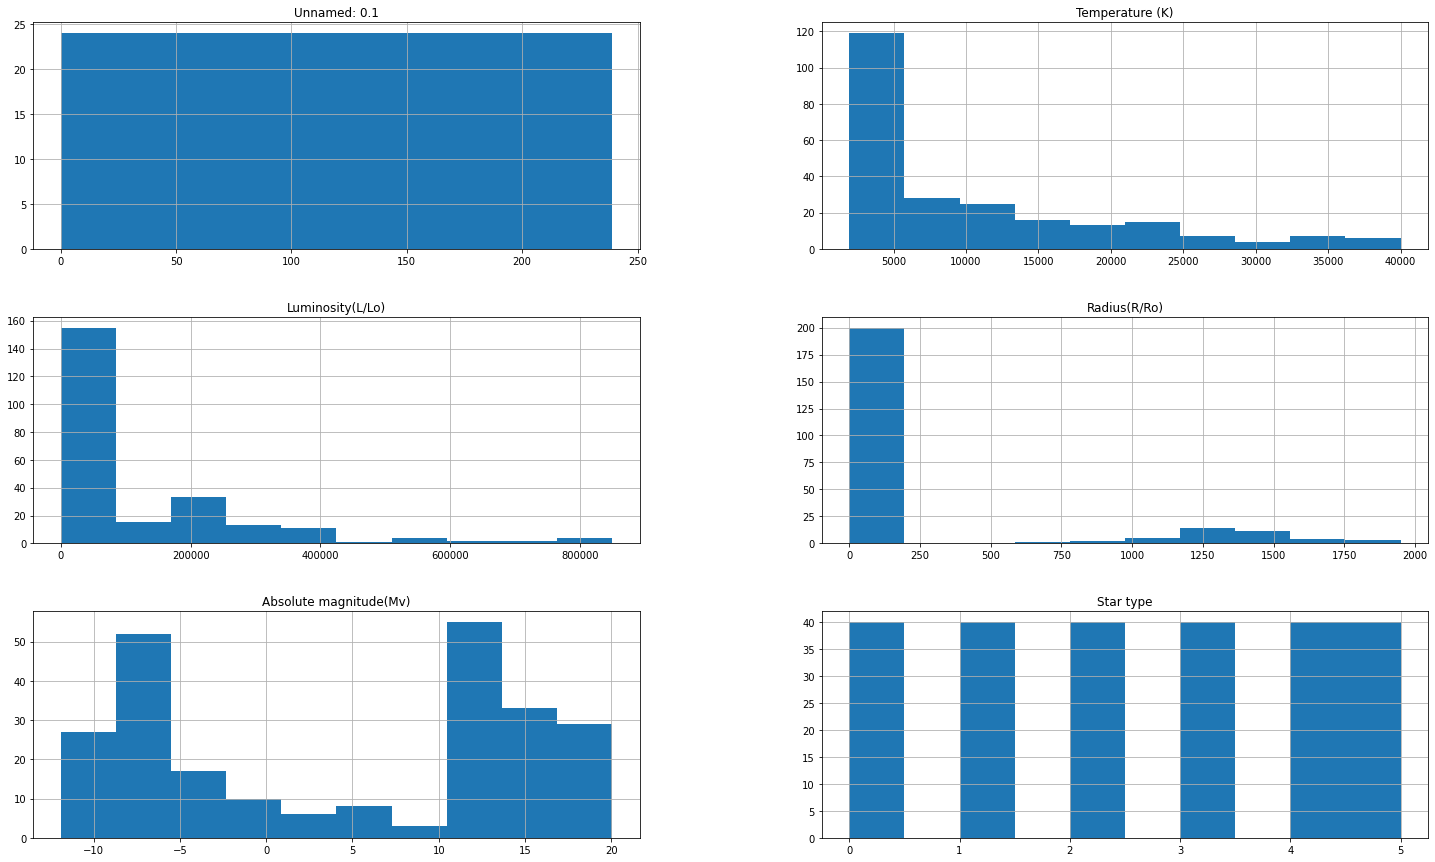


Размер датасета: (240, 7)

Пропуски
Unnamed: 0.1              0
Temperature (K)           0
Luminosity(L/Lo)          0
Radius(R/Ro)              0
Absolute magnitude(Mv)    0
Star type                 0
Star color                0
dtype: int64


,Unnamed: 0.1,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color
125,125,3225,0.000760,0.12100,19.630,0,Red
198,198,3324,0.006500,0.47100,12.780,1,Red
64,64,2935,0.000140,0.11600,18.890,0,Red
239,239,37882,294903.000000,1783.00000,-7.800,5,Blue
147,147,14732,0.000110,0.00892,12.890,2,white
46,46,3575,123000.000000,45.00000,-6.780,4,Red
122,122,3218,0.000540,0.11000,20.020,0,Red
90,90,5300,0.590000,0.91000,5.490,3,yellow-white
71,71,3607,0.022000,0.38000,10.120,1,Red
117,117,3625,74000.000000,876.00000,-10.250,5,Red


In [6]:
first_look(data)

## Краткий вывод

Данные загружены и бегло просмотрены.

Из положительных моментов - нет пропусков и дубликатов.

В остальном виден довольно неравномерный разброс данных по числовым столбцам, потребуется нормализация.

Обнаружены неявные дубликаты в столбце с цветом звезды.

Ну и названия столбцов неплохо бы превести к более удобному виду.

# Предобработка и анализ данных

In [7]:
data = data.drop('Unnamed: 0.1', axis=1)

In [8]:
# Упростим названия колонок
data.columns = ['temperature', 'luminosity', 'radius', 'abs_magnitude', 'type', 'color']

# и переставим целевой признак в конец

data = data[['luminosity', 'radius', 'abs_magnitude', 'type', 'color', 'temperature']]

In [9]:
data['color'].unique()

array(['Red', 'Blue White', 'White', 'Yellowish White', 'Blue white',
       'Pale yellow orange', 'Blue', 'Blue-white', 'Whitish',
       'yellow-white', 'Orange', 'White-Yellow', 'white', 'Blue ',
       'yellowish', 'Yellowish', 'Orange-Red', 'Blue white ',
       'Blue-White'], dtype=object)

In [10]:
# Унифицируем

# Как профессионально диванные астрономы, будем считать, 
# что yellowish white и yellow white (и подобные) - разные цвета

def remove_defis(x):
    return x.replace('-', ' ').strip()

data['color'] = data['color'].str.lower().apply(remove_defis).replace({'white yellow': 'yellow white', 'white blue': 'blue white'})

data['color'].unique()



array(['red', 'blue white', 'white', 'yellowish white',
       'pale yellow orange', 'blue', 'whitish', 'yellow white', 'orange',
       'yellowish', 'orange red'], dtype=object)

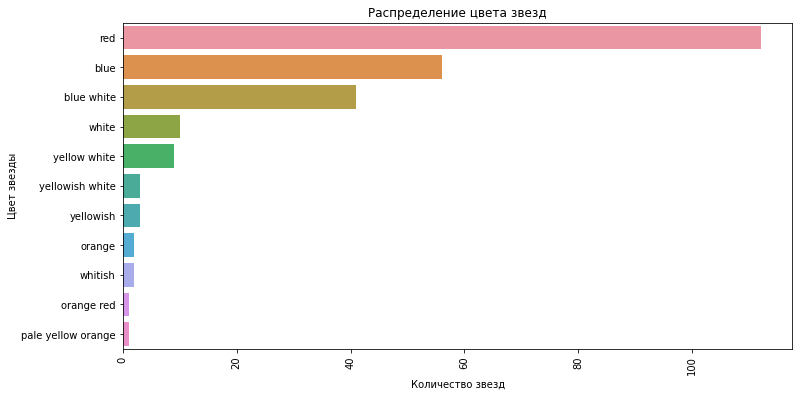

In [11]:
plt.figure(figsize=(12, 6))

sns.countplot(data=data, y='color', order = data['color'].value_counts().index)

plt.title('Распределение цвета звезд')
plt.ylabel('Цвет звезды')
plt.xlabel('Количество звезд')
plt.xticks(rotation= 90)

plt.show()

Как видим из графика, большая часть звезд - красные и синие, желтых разных оттенков заметно меньше.

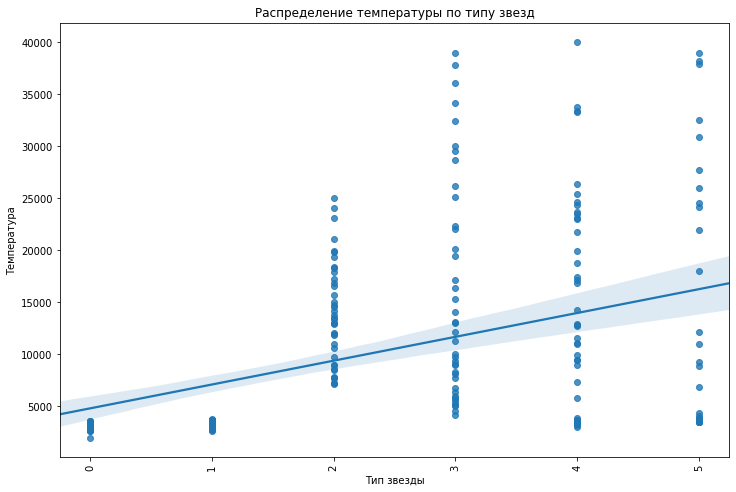

In [12]:
plt.figure(figsize=(12, 8))

sns.regplot(data=data, y='temperature', x='type', scatter=True, truncate=False)

plt.title('Распределение температуры по типу звезд')
plt.ylabel('Температура')
plt.xlabel('Тип звезды')
plt.xticks(rotation= 90)

plt.show()

Как видим, с повышением типа звезды повышается и температура.

Звезды типов 0 и 1 (коричневый и красный карлики соответственно) имеют невысокую температуру (до 5000).

Заметна тенденция повышения температуры с повышением номера типа звезды.

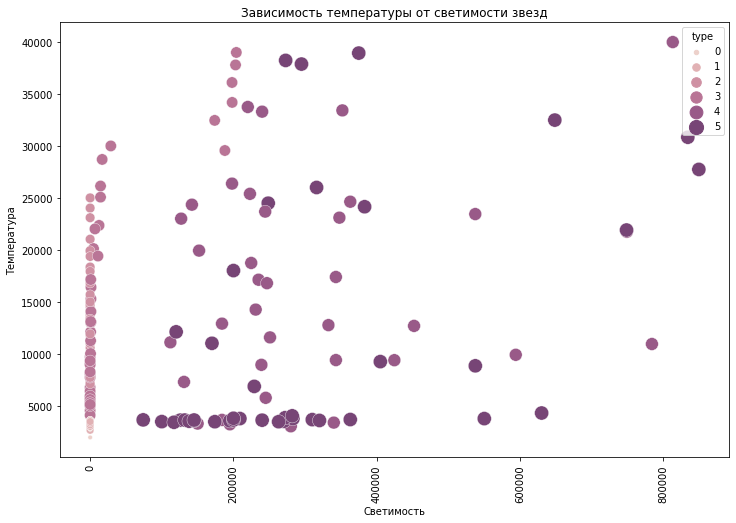

In [13]:
plt.figure(figsize=(12, 8))

sns.scatterplot(data=data, y='temperature', x='luminosity', 
    hue='type', hue_norm=(0, 7),
    size='type', sizes=(20, 200)
)

plt.title('Зависимость температуры от светимости звезд')
plt.ylabel('Температура')
plt.xlabel('Cветимость')
plt.xticks(rotation= 90)


plt.show()

Поскольку светимость "прыгает" на несколько порядков, разумно использовать логарифмические шкалы.

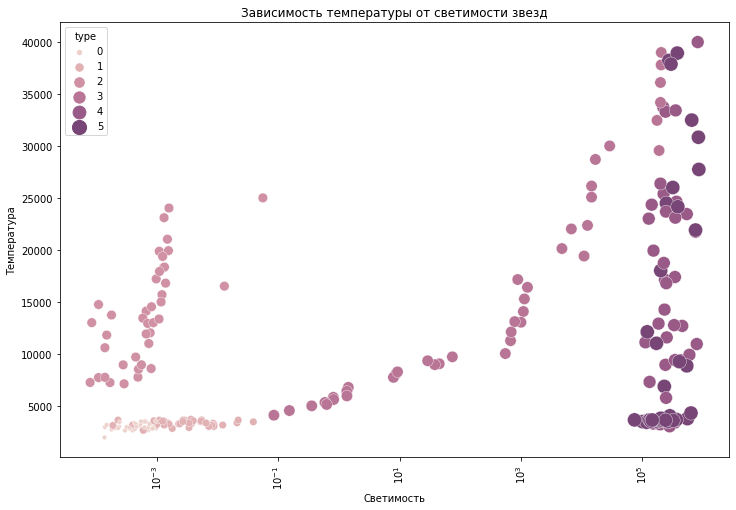

In [14]:
plt.figure(figsize=(12, 8))

sns.scatterplot(data=data, y='temperature', x='luminosity', 
    hue='type', hue_norm=(0, 7),
    size='type', sizes=(20, 200)
)

plt.title('Зависимость температуры от светимости звезд')
plt.ylabel('Температура')
plt.xlabel('Cветимость')
plt.xticks(rotation= 90)
plt.semilogx()


plt.show()

График показывает три группы корреляции — вертикальные группы со светимостью в районе $10^{–3}$ и $10^{5}$ и параболическую между ними.

Отметим зависимость от типа звезды в группах.

Аналогично посмотрим на связь температуры с радиусом и абсолютной звездной величиной.

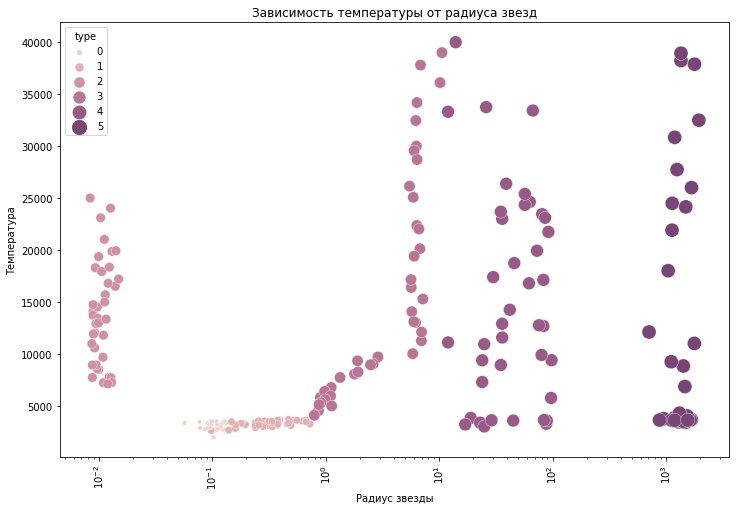

In [15]:
plt.figure(figsize=(12, 8))

sns.scatterplot(data=data, y='temperature', x='radius', 
    hue='type', hue_norm=(0, 7),
    size='type', sizes=(20, 200)
)

plt.title('Зависимость температуры от радиуса звезд')
plt.ylabel('Температура')
plt.xlabel('Радиус звезды')
plt.xticks(rotation= 90)
plt.semilogx()


plt.show()

Здесь видны шесть групп, практически точно повторяющие тип звезды.

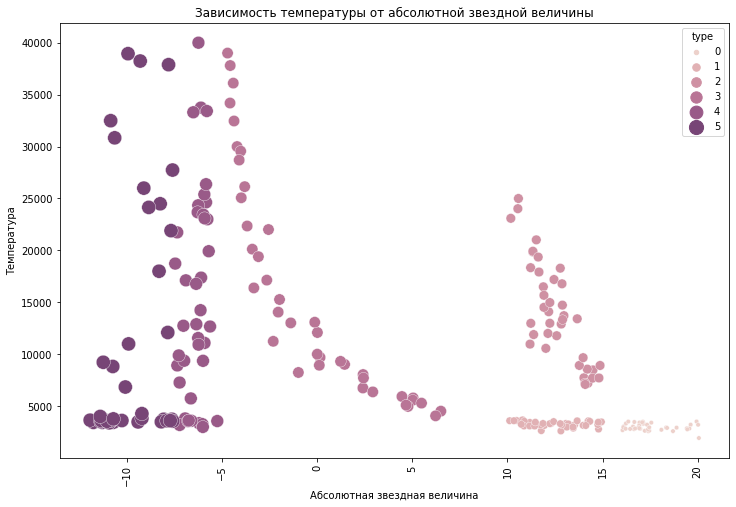

In [16]:
plt.figure(figsize=(12, 8))

sns.scatterplot(data=data, y='temperature', x='abs_magnitude', 
    hue='type', hue_norm=(0, 7),
    size='type', sizes=(20, 200)
)

plt.title('Зависимость температуры от абсолютной звездной величины')
plt.ylabel('Температура')
plt.xlabel('Абсолютная звездная величина')
plt.xticks(rotation= 90)
#plt.semilogx()


plt.show()

Аналогично предыдущему графику, видим несколько групп.

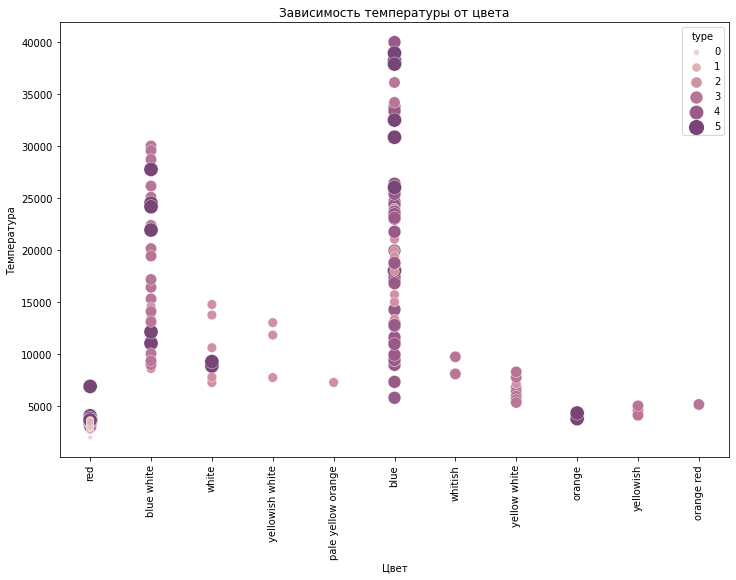

In [17]:
plt.figure(figsize=(12, 8))

sns.scatterplot(data=data, y='temperature', x='color', 
    hue='type', hue_norm=(0, 7),
    size='type', sizes=(20, 200)
)

plt.title('Зависимость температуры от цвета')
plt.ylabel('Температура')
plt.xlabel('Цвет')
plt.xticks(rotation= 90)



plt.show()

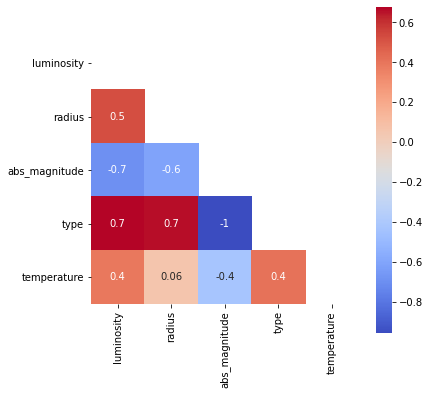

In [18]:
plt.figure(figsize=(6, 6))

sns.heatmap(
    data.corr(), 
    annot=True, 
    fmt='.1g',
    cmap= 'coolwarm', square=True,
    mask=np.triu(data.corr())
)
plt.show()

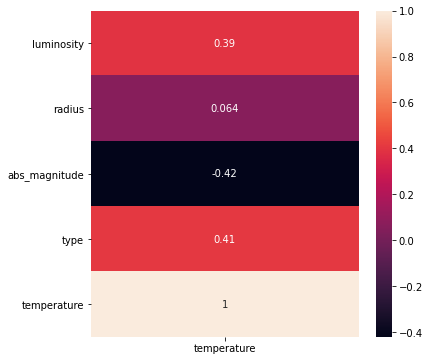

In [19]:
plt.figure(figsize=(6, 6))

sns.heatmap(data.corr()[['temperature']], annot = True)
plt.show()

Сильной линейной зависимости температуры от других параметров не видно, но заметны довольно сильные связи между типом звезды и ее яркостью и радиусом,  между абсолютной звездной величиной  и светимостью и радуисом.

Попробуем поискать нелинейные зависимости с помощью библиотеки phik.

In [21]:
phik_corr = data.phik_matrix()

phik_corr

interval columns not set, guessing: ['luminosity', 'radius', 'abs_magnitude', 'type', 'temperature']


,luminosity,radius,abs_magnitude,type,color,temperature
luminosity,1.000000,0.574964,0.709456,0.654026,0.443502,0.561692
radius,0.574964,1.000000,0.512414,0.635115,0.000000,0.236090
abs_magnitude,0.709456,0.512414,1.000000,0.915921,0.711969,0.709280
type,0.654026,0.635115,0.915921,1.000000,0.748776,0.603203
color,0.443502,0.000000,0.711969,0.748776,1.000000,0.683490
temperature,0.561692,0.236090,0.709280,0.603203,0.683490,1.000000


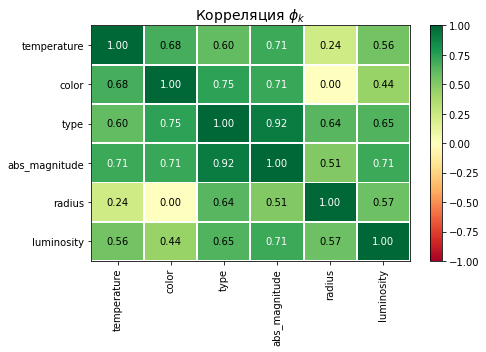

In [22]:

plot_correlation_matrix(
    phik_corr.values,
    x_labels=phik_corr.columns,
    y_labels=phik_corr.index,
    title='Корреляция $\phi_k$',
    identity_layout=True
)

In [23]:
# И преобразуем категориальный тип данных 
data['type'] = data['type'].astype('category')
data['color'] = data['color'].astype('category')

## Вывод

Проведен анализ исходных данных.

Выявлено, что:

* большая часть звезд - красные и синие, желтых разных оттенков заметно меньше;  
* есть тенденция повышения температуры с повышением номера типа звезды;
* обнаружены некоторые группы звезд: температура - светимость, температура - абсолютная звездная величина и температура - радиус;
* сильной линейной зависимости температуры от других параметров не видно, но заметны довольно сильные связи между типом звезды и ее яркостью и радиусом, между абсолютной звездной величиной и светимостью и радуисом;
* замечена довольная сильная нелинейная корреляция  между температурой и остальными параметрами, кроме радиуса.



# Построение базовой нейронной сети

In [24]:
# Разделим выборки на обучающую и тестовую

X = data.drop('temperature', axis=1)
y = data.temperature

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    train_size=.75, 
    random_state=RS 
)

In [25]:
# Проверим размер выборок

print(f'X_train: {X_train.shape}')

print(f'X_test: {X_test.shape}')

print(f'y_train: {y_train.shape}')

print(f'y_test: {y_test.shape}')

X_train: (180, 5)
X_test: (60, 5)
y_train: (180,)
y_test: (60,)


Сформируем пайплайн для масштабирования и кодирования данных.

In [26]:
pipeline = make_column_transformer(
    (
        OneHotEncoder(
            #drop='first', 
            handle_unknown='ignore'
            ), make_column_selector(dtype_include='category')
    ),
    (
        StandardScaler(
            ), make_column_selector(dtype_include='number')
    ), remainder='passthrough'

)

In [27]:
X_train = pipeline.fit_transform(X_train)

X_test = pipeline.transform(X_test)

In [28]:
# Любопытства ради - что вышло
pd.DataFrame(X_train.toarray())

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.210581,2.387328,-1.386881
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.621016,-0.450974,-0.130936
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.621057,-0.452971,0.887552
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.621057,-0.453467,1.182227
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.621057,-0.453630,0.802678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.621057,-0.453632,1.054439
176,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.701269,-0.381777,-0.959173
177,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.854048,-0.403738,-0.935809
178,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.621057,-0.453632,1.048718


Переведем полученные выборки в тензоры

In [29]:
X_train = torch.from_numpy(X_train.toarray()).float()
X_test = torch.from_numpy(X_test.toarray()).float()

y_train = torch.from_numpy(y_train.values).float()
y_test = torch.from_numpy(y_test.values).float()

Создадим класс нейтронной сети.

Количество скрытых слоев - 1.

In [30]:
class SkyNet(nn.Module):
    def __init__(
        self, 
        n_in_neurons, 
        n_hidden_neurons_1, 
        n_hidden_neurons_2, 
        n_out_neurons):
            super(SkyNet, self).__init__()
            self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)
            self.act1 = nn.LeakyReLU()
            
            self.fc2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)
            self.act2 = nn.LeakyReLU()
            
            self.fc3 = nn.Linear(n_hidden_neurons_2, n_out_neurons)        
            self.act3 = nn.LeakyReLU()

    def forward(self, x):
       x = self.fc1(x)
       x = self.act1(x)
       x = self.fc2(x)
       x = self.act2(x)
       x = self.fc3(x)
       x = self.act3(x)
       return x 

Установим количество нейронов.

In [31]:
n_in_neurons = X_train.shape[1] 
n_hidden_neurons_1 = 13
n_hidden_neurons_2 = 8
n_out_neurons = 1

Инициализируем нейронную сеть.

In [32]:
net = SkyNet(n_in_neurons, 
        n_hidden_neurons_1, 
        n_hidden_neurons_2, 
        n_out_neurons)

Инициализируем веса.

In [33]:
def init_weights(layer):
    if type(layer) == nn.Linear: 
        nn.init.kaiming_uniform_(layer.weight, mode='fan_in', nonlinearity='relu') 

net.apply(init_weights)

SkyNet(
  (fc1): Linear(in_features=18, out_features=13, bias=True)
  (act1): LeakyReLU(negative_slope=0.01)
  (fc2): Linear(in_features=13, out_features=8, bias=True)
  (act2): LeakyReLU(negative_slope=0.01)
  (fc3): Linear(in_features=8, out_features=1, bias=True)
  (act3): LeakyReLU(negative_slope=0.01)
)

In [34]:
# Оптимизатор и фунция потерь

optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

loss = nn.MSELoss()

In [35]:
# Обучим сеть

def train_skynet(num_epochs):
    result = {}

    for epoch in range(num_epochs):
        optimizer.zero_grad()

        preds = net.forward(X_train).flatten()

        loss_value = loss(preds, y_train)
    
        loss_value.backward()

        optimizer.step()

        if epoch % 1000 == 0 or epoch == num_epochs - 1:
            net.eval()
            test_preds = net.forward(X_test).flatten()
            rmse = (torch.sqrt(loss(test_preds, y_test)).item())
            #print('Epoch:', epoch)
            #print('RMSE:', rmse)
            result[epoch] = rmse
    return result, test_preds

result, predictions = train_skynet(10001)

In [36]:
print(f'Epoch: {min(result, key=result.get)}, RMSE: {min(result.values())}')

Epoch: 10000, RMSE: 4436.2734375


Даже без настроек параметров нейросети получили результат, достаточный для решения задачи. 

Попробуем поменять число нейронов на слоях для улучшения результата.

In [37]:
def neurons_test(n_hidden_neurons_1):
    neurons_test_dict = []

    for i in range(n_hidden_neurons_1, 4, -1):
        for j in range(i, 2, -1):
            
            net = SkyNet(X_train.shape[1], i, j, 1)
        
            net.apply(init_weights)

            optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
            loss = nn.MSELoss()
        
            result, predictions = train_skynet(10001)
            neurons_test_dict.append([X_train.shape[1], i, j, 1, min(result, key=result.get), min(result.values())])

            result = {}
            #print(neurons_test_dict)
    return neurons_test_dict


    

In [38]:
res = neurons_test(18)

In [39]:
res_df = pd.DataFrame(res, columns=['Входной слой', 'Слой 1', 'Слой 2', 'Выходной слой', 'Эпоха', 'RMSE']).sort_values(by='RMSE')

In [40]:
res_df.head(20)


# res_df[res_df['Слой 1'] == 13]


,Входной слой,Слой 1,Слой 2,Выходной слой,Эпоха,RMSE
1,18,18,17,1,7000,3385.527832
2,18,18,16,1,0,3588.040527
0,18,18,18,1,10000,3616.404785
132,18,5,3,1,9000,3837.328857
131,18,5,4,1,10000,3841.646484
130,18,5,5,1,6000,3849.910400
129,18,6,3,1,4000,3854.820312
128,18,6,4,1,9000,3857.829102
126,18,6,6,1,7000,3860.577637
127,18,6,5,1,10000,3860.854980


In [41]:
res_df.loc[(res_df['Слой 1'] == 13) & (res_df['Слой 2'] == 8)]

,Входной слой,Слой 1,Слой 2,Выходной слой,Эпоха,RMSE
75,18,13,8,1,7000,4909.058105


In [42]:
n_in_neurons = X_train.shape[1] 
n_hidden_neurons_1 = 13
n_hidden_neurons_2 = 8
n_out_neurons = 1

In [43]:
net = SkyNet(n_in_neurons, 
        n_hidden_neurons_1, 
        n_hidden_neurons_2, 
        n_out_neurons)

net.apply(init_weights)

optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
loss = nn.MSELoss()

result, predictions = train_skynet(10001)
print(f'Epoch: {min(result, key=result.get)}, RMSE: {min(result.values())}')

Epoch: 10000, RMSE: 4333.10400390625


In [44]:
net = SkyNet(18, 18, 17, 1)

net.apply(init_weights)

optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
loss = nn.MSELoss()

result, predictions = train_skynet(10001)

print(f'Epoch: {min(result, key=result.get)}, RMSE: {min(result.values())}')


Epoch: 10000, RMSE: 4207.8076171875


Попробуем поменять функции активации

In [45]:
net.act1 = nn.RReLU()

result, predictions = train_skynet(10001)

print(f'Epoch: {min(result, key=result.get)}, RMSE: {min(result.values())}')

Epoch: 10000, RMSE: 3651.43798828125


In [46]:
net.act1 = nn.ReLU()

result, predictions = train_skynet(10001)

print(f'Epoch: {min(result, key=result.get)}, RMSE: {min(result.values())}')

Epoch: 3000, RMSE: 3585.11083984375


In [47]:
net.act1 = nn.ReLU6()

result, predictions = train_skynet(10001)

print(f'Epoch: {min(result, key=result.get)}, RMSE: {min(result.values())}')

Epoch: 4000, RMSE: 3953.0634765625


In [48]:
net.act1 = nn.RReLU()
net.act2 = nn.RReLU()

result, predictions = train_skynet(10001)

print(f'Epoch: {min(result, key=result.get)}, RMSE: {min(result.values())}')

Epoch: 6000, RMSE: 3878.0966796875


In [49]:
net.act1 = nn.LeakyReLU()
net.act2 = nn.ReLU()

result, predictions = train_skynet(10001)

print(f'Epoch: {min(result, key=result.get)}, RMSE: {min(result.values())}')

Epoch: 2000, RMSE: 3579.328369140625


In [50]:
net.act1 = nn.ReLU6()
net.act2 = nn.ReLU()

result, predictions = train_skynet(10001)

print(f'Epoch: {min(result, key=result.get)}, RMSE: {min(result.values())}')

Epoch: 7000, RMSE: 3790.919921875


In [51]:
net = SkyNet(18, 18, 17, 1)

net.apply(init_weights)

optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
loss = nn.MSELoss()

activators = [nn.ReLU(), nn.LeakyReLU(), nn.RReLU(), nn.ReLU6()]

act_result = []

for act_1 in activators:
    for act_2 in activators:
        for act_3 in activators:
            net.act1 = act_1
            net.act2 = act_2
            net.act3 = act_3
            result, predictions = train_skynet(10001)
            act_result.append([
                str(act_1),
                str(act_2), 
                str(act_3),
                min(result, key=result.get),
                min(result.values())
                ])
            result ={}




In [52]:
act_result_df = pd.DataFrame(act_result, columns=['Activator1', 'Activator2', 'Activator3', 'Epoch', 'RMSE'])

act_result_df.sort_values(by='RMSE').head()

,Activator1,Activator2,Activator3,Epoch,RMSE
1,ReLU(),ReLU(),LeakyReLU(negative_slope=0.01),1000,3717.965576
0,ReLU(),ReLU(),ReLU(),10000,3889.436035
2,ReLU(),ReLU(),"RReLU(lower=0.125, upper=0.3333333333333333)",0,3982.255371
10,ReLU(),"RReLU(lower=0.125, upper=0.3333333333333333)","RReLU(lower=0.125, upper=0.3333333333333333)",5000,4792.092285
9,ReLU(),"RReLU(lower=0.125, upper=0.3333333333333333)",LeakyReLU(negative_slope=0.01),10000,5121.417969


In [53]:
net = SkyNet(18, 18, 17, 1)

net.apply(init_weights)

optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
loss = nn.MSELoss()

net.act1 = nn.ReLU()
net.act2 = nn.ReLU()
net.act3 = nn.LeakyReLU()

result, predictions = train_skynet(10001)

print(f'Epoch: {min(result, key=result.get)}, RMSE: {min(result.values())}')

Epoch: 10000, RMSE: 3908.562744140625


Лучшие результаты получаются при использовании функций активации ReLU(), ReLU() и LeakyReLU().

Метрика (RMSE) составила 3829.41.

Построим график по предсказаниям сети и фактическими значениями.

In [54]:
visual_df = pd.DataFrame({'Fact': y_test.detach().numpy(), 'Prediction': predictions.detach().numpy()})

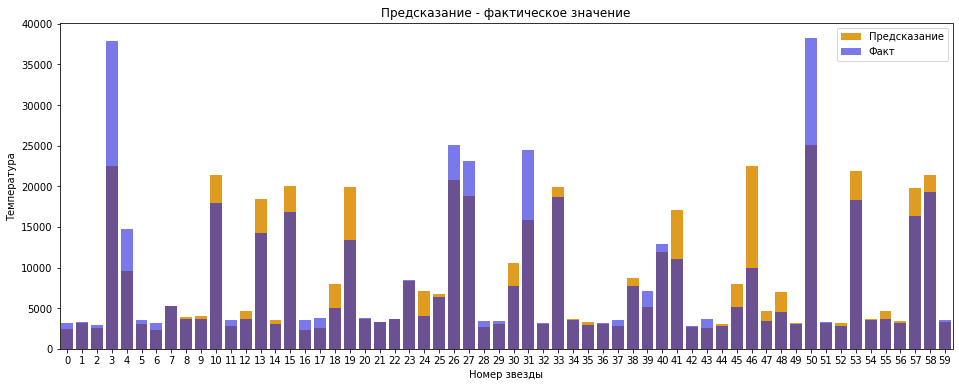

In [55]:

plt.figure(figsize=(16, 6))

sns.barplot(data=visual_df, x=visual_df.index, y='Prediction', color='orange', label='Предсказание')
sns.barplot(data=visual_df, x=visual_df.index, y='Fact', color='blue', label='Факт', alpha=.6)
plt.title('Предсказание - фактическое значение')
plt.ylabel('Температура')
plt.xlabel('Номер звезды')
plt.legend()

plt.show()


## Вывод

Построена нейронная сеть для предсказания температуры звезды.

Для улучшения качества сети проведен ряд экспериментов с количеством нейронов и типом функции активации.

Достигнут показатель целевой метрики (RMSE): 3829.41.



# Улучшение нейронной сети

## Обучение по батчам

Модифицируем функцию обучения сети для работы по батчам

In [56]:
def train_skynet_with_batch(num_epochs, batch_size):
    result = {}

    num_batches = ceil(len(X_train)/batch_size)

    for epoch in range(num_epochs):

        order = np.random.permutation(len(X_train))
        
        for batch_idx in range(num_batches):
            start = batch_idx * batch_size
            end = start + batch_size
        
            optimizer.zero_grad()

            batch_idxs = order[start:end]

            X_batch = X_train[batch_idxs]
            y_batch = y_train[batch_idxs]

            preds = net.forward(X_batch).flatten()

            loss_value = loss(preds, y_batch)
        
            loss_value.backward()

            optimizer.step()

            if epoch % 1000 == 0 or epoch == num_epochs - 1:
                net.eval()
                test_preds = net.forward(X_test).flatten()
                rmse = (torch.sqrt(loss(test_preds, y_test)).item())
                #print('Epoch:', epoch)
                #print('RMSE:', rmse)
                result[epoch] = rmse
    return result, test_preds



In [57]:
result, predictions = train_skynet_with_batch(10001, 30)

print(f'Epoch: {min(result, key=result.get)}, RMSE: {min(result.values())}')

Epoch: 10000, RMSE: 3702.41796875


Метрика стала лучше (3530.78)

## Batch Normalization

Создадм новый класс сети с Batch Normalization

In [58]:
class SkyNet_ver2(nn.Module):
    def __init__(
        self, 
        n_in_neurons, 
        n_hidden_neurons_1, 
        n_hidden_neurons_2, 
        n_out_neurons):
            super(SkyNet_ver2, self).__init__()
            self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)
            self.batch1 = nn.BatchNorm1d(n_hidden_neurons_1)
            self.act1 = nn.ReLU()
            
            self.fc2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)
            self.batch2 = nn.BatchNorm1d(n_hidden_neurons_2)
            self.act2 = nn.ReLU()
            
            self.fc3 = nn.Linear(n_hidden_neurons_2, n_out_neurons)
            self.batch3 = nn.BatchNorm1d(n_out_neurons)
            self.act3 = nn.LeakyReLU()

    def forward(self, x):
       x = self.fc1(x)
       x = self.batch1(x)
       x = self.act1(x)
       x = self.fc2(x)
       x = self.batch2(x)
       x = self.act2(x)
       x = self.fc3(x)
       x = self.batch3(x)
       x = self.act3(x)
       return x 

In [59]:
net = SkyNet_ver2(18, 18, 17, 1)

net.apply(init_weights)

optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
loss = nn.MSELoss()

result_batch, predictions_batch = train_skynet_with_batch(10001, 30)

print(f'Epoch: {min(result, key=result.get)}, RMSE: {min(result.values())}')


Epoch: 10000, RMSE: 3702.41796875


Метрика практически не изменилась. 

Попробуем подобрать оптимальные значения эпох и батчей.

In [60]:
res_batch = []
preds_batch = []

for epoch in tqdm(range(10000, 14001, 2000)):
    for batch in tqdm(range(20, 80, 10)):
        result_batch, predictions_batch = train_skynet_with_batch(epoch, batch)
        res_batch.append([epoch, batch, min(result_batch, key=result_batch.get), min(result_batch.values())])
        preds_batch.append(predictions_batch)


pd.DataFrame(res_batch, columns=['Epoch_total', 'Batches_total', 'Best_epoch', 'RMSE']).sort_values(by='RMSE')


100%|██████████| 3/3 [26:34<00:00, 531.39s/it]


,Epoch_total,Batches_total,Best_epoch,RMSE
0,10000,20,1000,3524.720215
1,10000,30,2000,3574.573486
2,10000,40,0,3696.499512
3,10000,50,0,4305.344238
4,10000,60,0,4760.411133
5,10000,70,0,5300.386719
6,12000,20,1000,5654.487793
7,12000,30,3000,6023.469238
8,12000,40,0,6427.657227
12,14000,20,7000,6809.880859


Метрика не улучшилась.

## DropOut

Попробуем "выключить" часть нейронов с помощью DropOut.

Модифицируем класс сети.

In [61]:
class SkyNet_ver2_dropout(nn.Module):
    def __init__(
        self, 
        n_in_neurons, 
        n_hidden_neurons_1, 
        n_hidden_neurons_2, 
        n_out_neurons):
            super(SkyNet_ver2_dropout, self).__init__()
            self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)
            self.drop1 = nn.Dropout(p=0.7)
            self.act1 = nn.ReLU()
            
            self.fc2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)
            self.drop2 = nn.Dropout(p=0.5)
            self.act2 = nn.ReLU()
            
            self.fc3 = nn.Linear(n_hidden_neurons_2, n_out_neurons)
            self.drop3 = nn.Dropout(p=0.3)
            self.act3 = nn.ReLU()

    def forward(self, x):
       x = self.fc1(x)
       x = self.drop1(x)
       x = self.act1(x)
       x = self.fc2(x)
       x = self.drop2(x)
       x = self.act2(x)
       x = self.fc3(x)
       x = self.drop3(x)
       x = self.act3(x)
       return x 

In [62]:
net = SkyNet_ver2_dropout(18, 18, 18, 1)

net.apply(init_weights)

optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
loss = nn.MSELoss()

result_dropout, predictions_dropout = train_skynet_with_batch(10001, 30)

print(f'Epoch: {min(result, key=result.get)}, RMSE: {min(result.values())}')


Epoch: 10000, RMSE: 3702.41796875


Метрика стала лучше (3530.78).

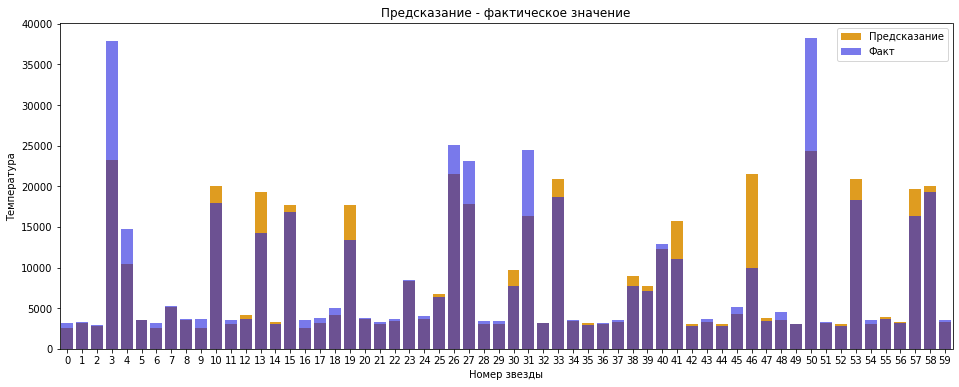

In [63]:
visual_df = pd.DataFrame({'Fact': y_test.detach().numpy(), 'Prediction': predictions_dropout.detach().numpy()})


plt.figure(figsize=(16, 6))

sns.barplot(data=visual_df, x=visual_df.index, y='Prediction', color='orange', label='Предсказание')
sns.barplot(data=visual_df, x=visual_df.index, y='Fact', color='blue', label='Факт', alpha=.6)
plt.title('Предсказание - фактическое значение')
plt.ylabel('Температура')
plt.xlabel('Номер звезды')
plt.legend()

plt.show()


# Выводы

На основе датасета с параметрами звезд проведен исследовательский анализ данных.

Выявлено, что:
* есть тенденция повышения температуры с повышением номера типа звезды;
* обнаружены нелинейные зависимости между температурой и остальными параметрами, кроме радиуса.

Построена базовая модель нейронной сети для предсказания температуры звезды.

Подобраны параметры слоев сети, функций активации. 

На графике представлена разница мезжду предсказаниями базовой модели и фактическими значениями температуры.

![Alt text](image-3.png)

На основе базовой модели разработана более сложная модель, которая была оптимизированая тремя методами.

1. Обучение по батчам

Метрика модели не улучшилась.

2. Batch Normalization

Метрика модели не улучшилась.

3. DropOut

Метрика улучшилась до значения 3530.78.

На графике представлена разница между предсказаниями оптимизированной модели и фактическими значениями температуры.


![Alt text](image-2.png)


Рекомендуется к использованию модель нейронной сети с DropOut.